In [228]:
%matplotlib inline
from __future__ import division, print_function
import sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib.ticker import NullFormatter
from astropy import units as u
import fitsio
import pandas as pd
from astropy.io import ascii

from desitarget.targetmask import desi_mask

In [229]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

In [230]:
def cut(ramin, ramax, decmin, decmax, catalog):
    
    mask = np.logical_and(catalog['RA'] >= ramin, catalog['RA'] <= ramax)
    mask &= np.logical_and(catalog['DEC'] >= decmin, catalog['DEC'] <= decmax)
    cat = catalog[mask]
    print('CUT #:',len(cat))
    
    return cat

In [231]:
def get_mag_decals(df):
    
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    rmag =  flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    w1mag = flux_to_mag(df['FLUX_W1']/df['MW_TRANSMISSION_W1'])
    Gmag = df['GAIA_PHOT_G_MEAN_MAG']
    
    return gmag, rmag, zmag, w1mag, Gmag

In [414]:
def target_con(df, NAME):
    
    target = ("BGS_ANY", "QSO", "LRG", "ELG", "BAD_SKY", "NO_TARGET", "BRIGHT_OBJECT", "MWS_ANY", "STD", "STD_BRIGHT", "STD_WD", "IN_BRIGHT_OBJECT", "NEAR_BRIGHT_OBJECT")
    print('Total #%s:  %g'%(NAME,len(df)))
    print('Of which...')

    for i in target:
    
        target_per = len(df[((df["DESI_TARGET"] & desi_mask[i])!=0)])
        print('%s: %2.4g %%' %(i, 100*target_per/len(df)))

In [232]:
def load_cat(catalog):
    
    # Load DESI target catalog
    columns0 = ['RA', 'DEC', 'TYPE', 'DESI_TARGET', 'BRIGHTSTARINBLOB', 'GAIA_PHOT_G_MEAN_MAG', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_G', 
                'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R','MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1',
               'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z',
               'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z']
    cat0 = fitsio.read(catalog, columns=columns0)
    print('Lenght full DR7',len(cat0))
    
    cat0S = cut(200, 230, -2,5, cat0)
    #Cut Fluxes < 0 to avoid singularities in 'flux_to_mag' 
    cat = cat0S[(cat0S['FLUX_R'] > 0) & (cat0S['FLUX_G'] > 0) & (cat0S['FLUX_Z'] > 0)]
    #cat = Table.read(cat)
    print('Lenght DR7 sample',len(cat))

    rmag = flux_to_mag(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat['FLUX_G']/cat['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat['FLUX_Z']/cat['MW_TRANSMISSION_Z'])
    
    # Require 2+ exposures in grz
    mask = (cat['NOBS_G']>=1) & (cat['NOBS_R']>=1) & (cat['NOBS_Z']>=1)
    mask &= np.logical_and(rmag>15, rmag<20)
    mask &= (cat['FRACMASKED_G']<0.6) & (cat['FRACMASKED_R']<0.6) & (cat['FRACMASKED_Z']<0.6) 
    mask &= (cat['FRACFLUX_G']<10) & (cat['FRACFLUX_R']<10) & (cat['FRACFLUX_Z']<10)
    mask &= (cat['FLUX_IVAR_G']>0) & (cat['FLUX_IVAR_R']>0) & (cat['FLUX_IVAR_Z']>0)
    mask &= gmag + zmag - 2*rmag < 1.5
    mask &= gmag - rmag > -1
    #add this line to apply 'BRIGHTSTARINBLOB'
    mask &= [not i for i in cat['BRIGHTSTARINBLOB']]
    #mask &= cat['GAIA_PHOT_G_MEAN_MAG'] != 0
    
    print('Lenght DR7 sample after cuts', len(cat[mask]))

    return cat[mask], cat0S

# Conditions

* 15 < r < 20
* fracmasked_r<0.6 & fracmasked_g<0.6 & fracmasked_z<0.6
* fracflux_r<10 & fracflux_g<10 & fracflux_z<10
* nobs_r>0 & nobs_g>0 & nobs_z>0
* flux_ivar_r>0 & flux_ivar_g>0 & flux_ivar_z>0
* g+z-2*r<1.5 and g-r>-1. --This cuts junk where the r band or g band are anomalously bright


In [233]:
cat, cat0 = load_cat('targets-dr7.1-0.23.0.fits')

Lenght full DR7 72660205
CUT #: 1557493
Lenght DR7 sample 1554588
Lenght DR7 sample after cuts 658013


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


363632


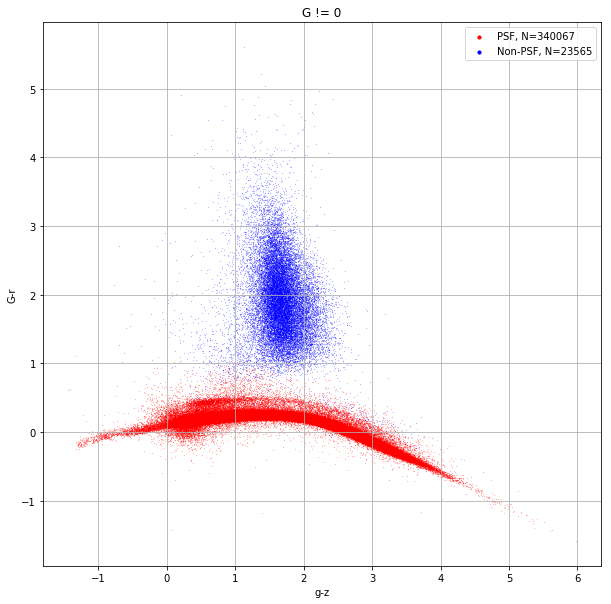

In [234]:
#G-r vs g-z
#del gmag, rmag, zmag, Gmag
gmag, rmag, zmag, w1mag, Gmag = get_mag_decals(cat)

star = cat['TYPE'] == b'PSF ' 
galaxy = cat['TYPE'] != b'PSF '
maskt = Gmag != 0
print(len(cat[maskt]))
#print(len(cat[Gmag == 0]))
#print(len(cat[maskt]) + len(cat[Gmag == 0]))

plt.figure(figsize=(10, 10))
plt.scatter(gmag[(star) & (maskt)] - zmag[(star) & (maskt)], Gmag[(star) & (maskt)] - rmag[(star) & (maskt)], s=0.01, color='red', label = r'PSF, N=%g' %(len(gmag[(star) & (maskt)])))
plt.scatter(gmag[(galaxy) & (maskt)] - zmag[(galaxy) & (maskt)], Gmag[(galaxy) & (maskt)] - rmag[(galaxy) & (maskt)], s=0.01, color='blue', label = r'Non-PSF, N=%g' %(len(gmag[(galaxy) & (maskt)])))
plt.xlabel(r'g-z')
plt.ylabel(r'G-r')
plt.title(r'G != 0')
plt.grid()
lgnd = plt.legend(fontsize=10)
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

##### STAR-GALAXY with GAIA:

* GAIA\_GAL = np.concatenate((cat[Grr $>$ 0.9], cat[Gmag == 0])) 

* GAIA\_STAR = cat[Grr $<$ 0.9 & Gmag != 0]

##### STAR-GALAXY with DECaLS DR7:

* DECALS\_GAL = cat[cat['TYPE'] != b'PSF ']

* DECALS\_STAR = cat[cat['TYPE'] == b'PSF '] 

cat with Grr > 0.9: 23233
cat with Gmag = 0: 294381
concatenate cat: 317614


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


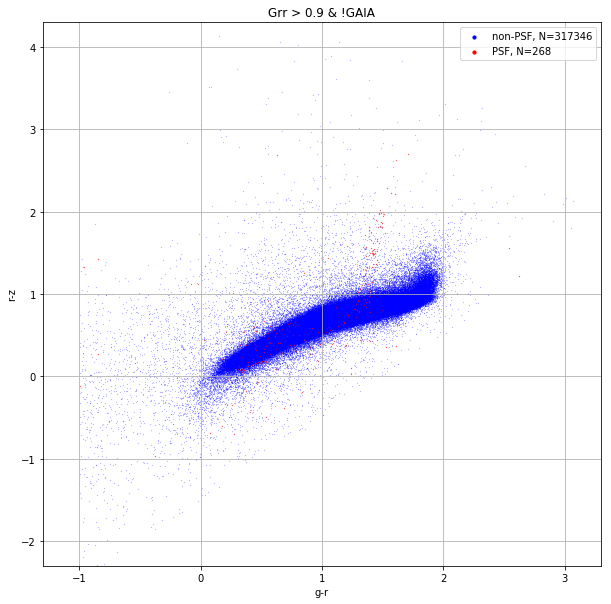

In [419]:
#r-z vs g-r
Grr = Gmag - rmag
cat_bgs = np.concatenate((cat[Grr > 0.9], cat[Gmag == 0]))
print('cat with Grr > 0.9:',len(cat[Grr > 0.9]))
print('cat with Gmag = 0:',len(cat[Gmag == 0]))
print('concatenate cat:', len(cat_bgs))

g, r, z, w1, G = get_mag_decals(cat_bgs)

gr_star = g[cat_bgs['TYPE'] == b'PSF '] - r[cat_bgs['TYPE'] == b'PSF ']
rz_star = r[cat_bgs['TYPE'] == b'PSF '] - z[cat_bgs['TYPE'] == b'PSF ']
gr_galaxy = g[cat_bgs['TYPE'] != b'PSF '] - r[cat_bgs['TYPE'] != b'PSF ']
rz_galaxy = r[cat_bgs['TYPE'] != b'PSF '] - z[cat_bgs['TYPE'] != b'PSF ']

plt.figure(figsize=(10, 10))

plt.scatter(gr_galaxy, rz_galaxy, s=0.01, color='blue', label = r'non-PSF, N=%g' %(len(gr_galaxy)))
plt.scatter(gr_star, rz_star, s=0.08, color='red', label = r'PSF, N=%g' %(len(gr_star)))

#plt.scatter(gmag[Gmag == 0] - rmag[Gmag == 0], rmag[Gmag == 0] - zmag[Gmag == 0], s=0.1, color='red')
#plt.scatter(gmag[Grr > 0.9] - rmag[Grr > 0.9], rmag[Grr > 0.9] - zmag[Grr > 0.9], s=0.1, color='black')
plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
plt.title(r'Grr > 0.9 & !GAIA')
plt.xlim(-1.3, 3.3)
plt.ylim(-2.3, 4.3)
plt.grid()
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [415]:
target_con(cat[Grr > 0.9], 'G-r > 0.9')

Total #G-r > 0.9:  23233
Of which...
BGS_ANY: 99.63 %
QSO: 0.2755 %
LRG: 0.1248 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 0.1765 %
STD: 0.004304 %
STD_BRIGHT: 0.004304 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


In [416]:
target_con(cat[Gmag == 0], 'G == 0')

Total #G == 0:  294381
Of which...
BGS_ANY: 99.94 %
QSO: 0.005095 %
LRG: 4.755 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 0.05775 %
STD:  0 %
STD_BRIGHT:  0 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


In [421]:
target_con(cat[(Grr < 0.9) & (Gmag != 0)], 'G-r < 0.9')

Total #G-r < 0.9:  340399
Of which...
BGS_ANY: 0.1228 %
QSO: 2.389 %
LRG: 0.02027 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 97.08 %
STD: 11.04 %
STD_BRIGHT: 6.11 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


340399


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


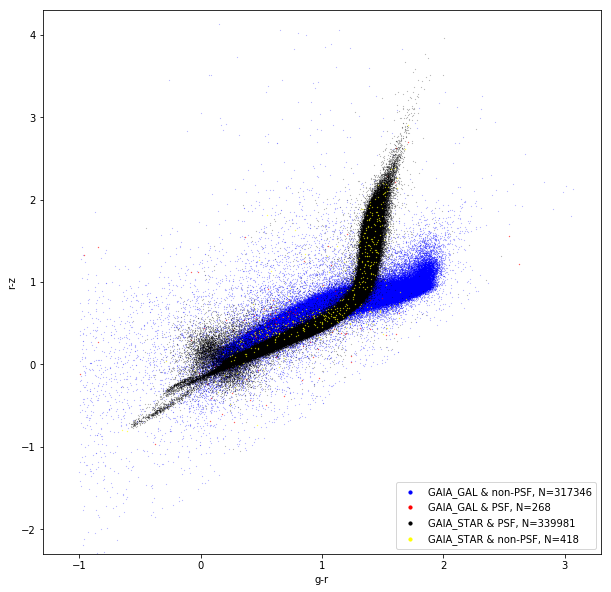

In [262]:
#r-z vs g-r
#Grr = Gmag - rmag
GAIA_GAL = np.concatenate((cat[Grr > 0.9], cat[Gmag == 0]))
GAIA_STAR = cat[(Grr  <  0.9) & (Gmag != 0)]
print(len(GAIA_STAR))

g1, r1, z1, w11, G1 = get_mag_decals(GAIA_GAL)
g2, r2, z2, w12, G2 = get_mag_decals(GAIA_STAR)

#GAIA GALAXIES
gr_GAL_psf = g1[GAIA_GAL['TYPE'] == b'PSF '] - r1[GAIA_GAL['TYPE'] == b'PSF ']
rz_GAL_psf = r1[GAIA_GAL['TYPE'] == b'PSF '] - z1[GAIA_GAL['TYPE'] == b'PSF ']
gr_GAL_nopsf = g1[GAIA_GAL['TYPE'] != b'PSF '] - r1[GAIA_GAL['TYPE'] != b'PSF ']
rz_GAL_nopsf = r1[GAIA_GAL['TYPE'] != b'PSF '] - z1[GAIA_GAL['TYPE'] != b'PSF ']

#GAIA STARS
gr_STAR_psf = g2[GAIA_STAR['TYPE'] == b'PSF '] - r2[GAIA_STAR['TYPE'] == b'PSF ']
rz_STAR_psf = r2[GAIA_STAR['TYPE'] == b'PSF '] - z2[GAIA_STAR['TYPE'] == b'PSF ']
gr_STAR_nopsf = g2[GAIA_STAR['TYPE'] != b'PSF '] - r2[GAIA_STAR['TYPE'] != b'PSF ']
rz_STAR_nopsf = r2[GAIA_STAR['TYPE'] != b'PSF '] - z2[GAIA_STAR['TYPE'] != b'PSF ']

plt.figure(figsize=(10, 10))

plt.scatter(gr_GAL_nopsf, rz_GAL_nopsf, s=0.01, color='blue', label = r'GAIA_GAL & non-PSF, N=%g' %(len(gr_GAL_nopsf)))
plt.scatter(gr_GAL_psf, rz_GAL_psf, s=0.08, color='red', label = r'GAIA_GAL & PSF, N=%g' %(len(gr_GAL_psf)))

plt.scatter(gr_STAR_psf, rz_STAR_psf, s=0.01, color='black', label = r'GAIA_STAR & PSF, N=%g' %(len(gr_STAR_psf)))
plt.scatter(gr_STAR_nopsf, rz_STAR_nopsf, s=0.08, color='yellow', label = r'GAIA_STAR & non-PSF, N=%g' %(len(gr_STAR_nopsf)))

plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
#plt.title(r'')
#plt.grid()
plt.xlim(-1.3, 3.3)
plt.ylim(-2.3, 4.3)
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [105]:
#Save catalogue for visualization in yymao:https://yymao.github.io/decals-image-list-tool/
t_psf= Table()
t_nopsf= Table()
CAT_PSF = cat_bgs[cat_bgs['TYPE'] == b'PSF ']
CAT_NOPSF = GAIA_STAR[GAIA_STAR['TYPE'] != b'PSF ']
t_psf['ra'] = CAT_PSF['RA']
t_psf['dec'] = CAT_PSF['DEC']
t_nopsf['ra'] = CAT_NOPSF['RA']
t_nopsf['dec'] = CAT_NOPSF['DEC']
#ascii.write(t_nopsf[:150], 'separation_NOPSF.dat', overwrite=True)

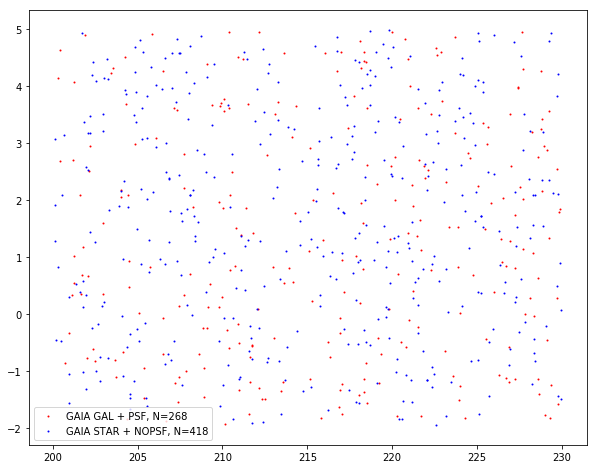

In [106]:
plt.figure(figsize=(10,8))
plt.scatter(t_psf['ra'], t_psf['dec'], s=1, color='red', label = r'GAIA GAL + PSF, N=%g' %(len(t_psf)))
plt.scatter(t_nopsf['ra'], t_nopsf['dec'], s=1, color='blue', label = r'GAIA STAR + NOPSF, N=%g' %(len(t_nopsf)))
plt.legend()

In [264]:
target_con(CAT_NOPSF, 'GAIA STAR + NOPSF')

Total #GAIA STAR + NOPSF:  418
Of which...
BGS_ANY: 100 %
QSO:  0 %
LRG:  0 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 0.4785 %
STD:  0 %


In [257]:
target_con(CAT_PSF, 'GAIA GAL + PSF')

Total #GAIA GAL + PSF:  268
Of which...
BGS_ANY:  0 %
QSO: 29.48 %
LRG: 1.493 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 77.24 %
STD: 0.3731 %


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


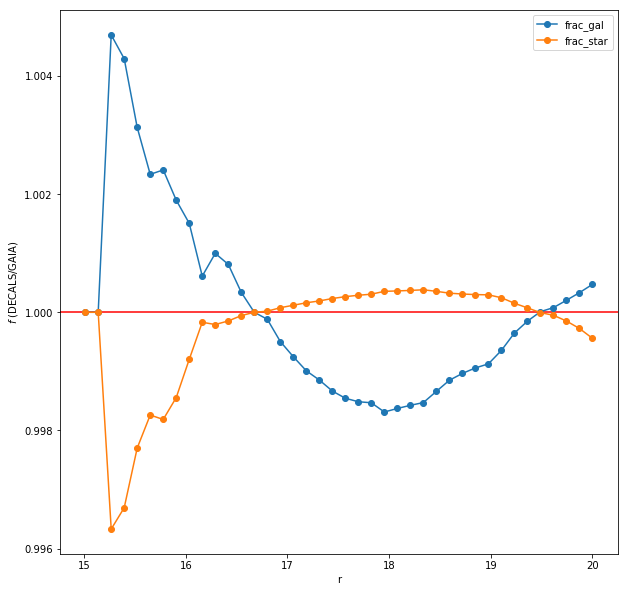

In [242]:
r_tmp = np.linspace(15.01,20,40)
frac_gal = np.zeros(len(r_tmp), dtype='f8')
frac_star = np.zeros(len(r_tmp), dtype='f8')
del g,r,z, w1, G
g, r, z, w1, G = get_mag_decals(cat)
j = 0
for i in r_tmp:
    DECALS_GAL = cat[r <= i]
    DECALS_STAR = cat[r <= i]
    frac_gal[j] = len(DECALS_GAL[DECALS_GAL['TYPE'] != b'PSF '])/len(GAIA_GAL[r1 <= i])
    frac_star[j] = len(DECALS_STAR[DECALS_STAR['TYPE'] == b'PSF '])/len(GAIA_STAR[r2 <= i])
    j = j + 1

plt.figure(figsize=(10, 10))

plt.axhline(1, color='red')
plt.plot(r_tmp, frac_gal, marker='o', label=r'frac_gal')
plt.plot(r_tmp, frac_star, marker='o', label=r'frac_star')

plt.xlabel(r'r')
plt.ylabel(r'$f$ (DECALS/GAIA)')
lgnd = plt.legend()
plt.show()

For 'bgs.gr_rz.all.gif' we select:

* Not GAIA
* G-r > 0.9
* 0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4
* -1 < G-rr < 0.4 and z-W1-(g-r)>-0.5

and then we concatenate everything.

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


G-r > 0.9= 23233
Not GAIA= 294381
0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4= 2744
-1 < G-rr < 0.4 and z-W1-(g-r)>-0.5= 7246
TOTAL=327604
CONCATENATE CAT= 327604


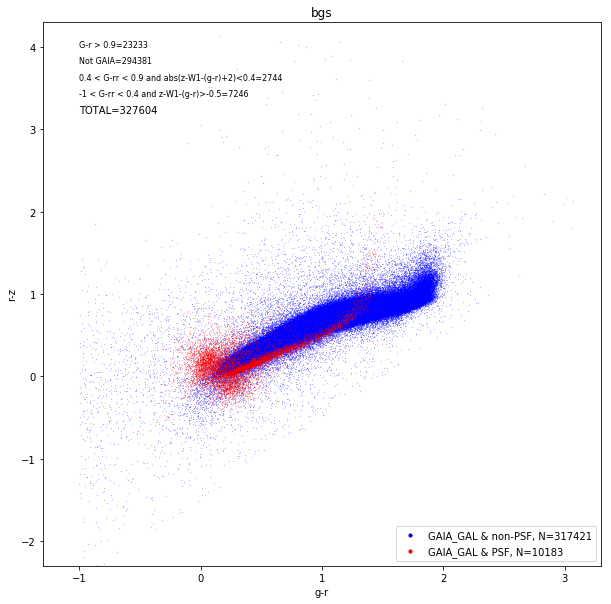

In [107]:
del GAIA_GAL
del g,r,z,w1,G
mask_bgs1 = np.logical_and(Grr < 0.9, Grr > 0.4)
mask_bgs1 &= abs(zmag - w1mag - (gmag - rmag) + 2) < 0.4

mask_bgs2 = np.logical_and(Grr < 0.4, Grr > -1)
mask_bgs2 &= zmag - w1mag - (gmag - rmag) > -0.5

GAIA_GAL = np.concatenate((cat[Grr > 0.9], cat[Gmag == 0], cat[mask_bgs1], cat[mask_bgs2]))
print('G-r > 0.9=',len(cat[Grr > 0.9]))
print('Not GAIA=',len(cat[Gmag == 0]))
print('0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4=',len(cat[mask_bgs1]))
print('-1 < G-rr < 0.4 and z-W1-(g-r)>-0.5=',len(cat[mask_bgs2]))
print('TOTAL=%g' %(len(cat[Grr > 0.9])+len(cat[Gmag == 0])+len(cat[mask_bgs1])+len(cat[mask_bgs2])))

print('CONCATENATE CAT=',len(GAIA_GAL))

g, r, z, w1, G = get_mag_decals(GAIA_GAL)

#GAIA ULTIMATE GALAXIES
gr_GAL_psf = g[GAIA_GAL['TYPE'] == b'PSF '] - r[GAIA_GAL['TYPE'] == b'PSF ']
rz_GAL_psf = r[GAIA_GAL['TYPE'] == b'PSF '] - z[GAIA_GAL['TYPE'] == b'PSF ']
gr_GAL_nopsf = g[GAIA_GAL['TYPE'] != b'PSF '] - r[GAIA_GAL['TYPE'] != b'PSF ']
rz_GAL_nopsf = r[GAIA_GAL['TYPE'] != b'PSF '] - z[GAIA_GAL['TYPE'] != b'PSF ']

plt.figure(figsize=(10, 10))

plt.scatter(gr_GAL_nopsf, rz_GAL_nopsf, s=0.01, color='blue', label = r'GAIA_GAL & non-PSF, N=%g' %(len(gr_GAL_nopsf)))
plt.scatter(gr_GAL_psf, rz_GAL_psf, s=0.01, color='red', label = r'GAIA_GAL & PSF, N=%g' %(len(gr_GAL_psf)))
plt.text(-1, 4, r'G-r > 0.9=%g'%(len(cat[Grr > 0.9])), fontsize=8)
plt.text(-1, 3.8, r'Not GAIA=%g'%(len(cat[Gmag == 0])), fontsize=8)
plt.text(-1, 3.6, r'0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4=%g' %(len(cat[mask_bgs1])), fontsize=8)
plt.text(-1, 3.4, r'-1 < G-rr < 0.4 and z-W1-(g-r)>-0.5=%g' %(len(cat[mask_bgs2])), fontsize=8)
plt.text(-1,3.2, r'TOTAL=%g' %(len(cat[Grr > 0.9])+len(cat[Gmag == 0])+len(cat[mask_bgs1])+len(cat[mask_bgs2])), fontsize=10)

plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
plt.title(r'bgs')
#plt.grid()
plt.xlim(-1.3, 3.3)
plt.ylim(-2.3, 4.3)
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

Next, let's consider the sample with G-r<0.4.  There are 102K of
these, and they are overwhelmingly stars.  1080 of them have
type!='PSF' and even those mostly have stellar colors.  But there
are a fair number of AGN in the sample, as can be seen from looking
at z-W1-(g-r), in bgs.gr_zW.star.gif.  A cut of z-W1-(g-r)>-0.5
selects 2362 objects, which by colors in g-r vs r-z are mostly AGN
with a small admixture of F stars.  For whatever reason, the F stars
show more scatter in this z-W1 color than the rest of the stellar
locus.  2000 AGN in 75 sq deg is about 25 per square degree.

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


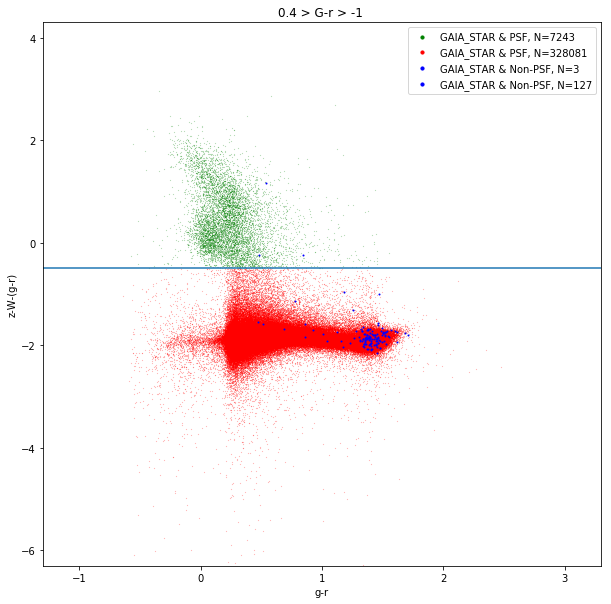

In [108]:
del GAIA_STAR
del g,r,z,w1,G

mask_star = np.logical_and(Grr < 0.4, Grr > -1)
GAIA_STAR = cat[mask_star]
g, r, z, w1, G = get_mag_decals(GAIA_STAR)
GAIA_STARup =GAIA_STAR[z - w1 - (g - r) > -0.5]
GAIA_STARdown =GAIA_STAR[z - w1 - (g - r) < -0.5]

g1, r1, z1, w11, G1 = get_mag_decals(GAIA_STARup)
g2, r2, z2, w12, G2 = get_mag_decals(GAIA_STARdown)

#GAIA ULTIMATE STARS UP
gr_psf_up = g1[GAIA_STARup['TYPE'] == b'PSF '] - r1[GAIA_STARup['TYPE'] == b'PSF ']
zw_psf_up = z1[GAIA_STARup['TYPE'] == b'PSF '] - w11[GAIA_STARup['TYPE'] == b'PSF '] - (gr_psf_up)
gr_nopsf_up = g1[GAIA_STARup['TYPE'] != b'PSF '] - r1[GAIA_STARup['TYPE'] != b'PSF ']
zw_nopsf_up = z1[GAIA_STARup['TYPE'] != b'PSF '] - w11[GAIA_STARup['TYPE'] != b'PSF '] - (gr_nopsf_up)
#GAIA ULTIMATE STARS DOWN
gr_psf_down = g2[GAIA_STARdown['TYPE'] == b'PSF '] - r2[GAIA_STARdown['TYPE'] == b'PSF ']
zw_psf_down = z2[GAIA_STARdown['TYPE'] == b'PSF '] - w12[GAIA_STARdown['TYPE'] == b'PSF '] - (gr_psf_down)
gr_nopsf_down = g2[GAIA_STARdown['TYPE'] != b'PSF '] - r2[GAIA_STARdown['TYPE'] != b'PSF ']
zw_nopsf_down = z2[GAIA_STARdown['TYPE'] != b'PSF '] - w12[GAIA_STARdown['TYPE'] != b'PSF '] - (gr_nopsf_down)

plt.figure(figsize=(10, 10))

plt.scatter(gr_psf_up, zw_psf_up, s=0.01, color='green', label = r'GAIA_STAR & PSF, N=%g' %(len(zw_psf_up)))
plt.scatter(gr_psf_down, zw_psf_down, s=0.01, color='red', label = r'GAIA_STAR & PSF, N=%g' %(len(zw_psf_down)))

plt.scatter(gr_nopsf_up, zw_nopsf_up, s=1, color='blue', label = r'GAIA_STAR & Non-PSF, N=%g' %(len(zw_nopsf_up)))
plt.scatter(gr_nopsf_down, zw_nopsf_down, s=1, color='blue', label = r'GAIA_STAR & Non-PSF, N=%g' %(len(zw_nopsf_down)))
plt.axhline(-0.5)

plt.xlabel(r'g-r')
plt.ylabel(r'z-W-(g-r)')
plt.title(r'0.4 > G-r > -1 ')
#plt.grid()
plt.xlim(-1.3, 3.3)
plt.ylim(-6.3, 4.3)
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [109]:
tG_psf= Table()

tG_psf['ra'] = GAIA_STARup['RA']
tG_psf['dec'] = GAIA_STARup['DEC']

ascii.write(tG_psf[::50], 'GAIA_STARup.dat', overwrite=True)

In [256]:
target_con(GAIA_STARup, 'GAIA STAR with z-w1-(g-r) > 0.5')

Total #GAIA STAR with z-w1-(g-r) > 0.5:  7246
Of which...
BGS_ANY: 0.0414 %
QSO: 93.2 %
LRG: 0.2346 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 29.11 %
STD: 1.09 %


This shows z-W1-(g-r) vs g-r.  The
z-W1-(g-r) color approximately flattens out the stellar locus to
lie around -2.
The objects with -2.4<z-W1-(g-r)<-1.6 are clearly stars in the g-r
vs r-z plot; they are about 50% of the 0.4<G-r<0.9 sample.  The
objects not in that band do not fall on the stellar locus.  Many
seem to be galaxies, from the image postage stamps.  Some may be
AGN.  And some may be F stars blended with redder things; I see a
little bit of an excess around the F star locus and just above it
in the g-r, r-z plot.  But at 0.5% of the total sample and with
some real galaxies, I think we should select them all.

#### Distribution...

In [391]:
def hist_decals(df, name, tuningL, tuningR, limit, LOG):
    
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    
    print('Z MAX-MIN=',df[name+'_Z'].max(), df[name+'_Z'].min())
    print('G MAX-MIN=',df[name+'_G'].max(), df[name+'_G'].min())
    print('R MAX-MIN=',df[name+'_R'].max(), df[name+'_R'].min())
    
    plt.figure(figsize=(12, 7))
    plt.hist(df[name+'_Z'][(df[name+'_Z'] < tuningR) & (df[name+'_Z'] > tuningL)], 500, histtype='step', cumulative=True, stacked=True, fill=False, label=r'z', linewidth=3.0)
    plt.hist(df[name+'_G'][(df[name+'_G'] < tuningR) & (df[name+'_G'] > tuningL)], 500, histtype='step', cumulative=True, stacked=True, fill=False, label=r'g', alpha=0.6, linewidth=3.0)
    plt.hist(df[name+'_R'][(df[name+'_R'] < tuningR) & (df[name+'_R'] > tuningL)], 500, histtype='step', cumulative=True, stacked=True, fill=False, label=r'r', alpha=0.5, linewidth=3.0)
    plt.axvline(x=limit, color=r'black')
    #plt.xlim(0, 30)
    plt.title(name)
    if LOG == 'loglog':
        plt.yscale('log')
        plt.xscale('log')
    if LOG == 'logx':
        plt.xscale('log')
    if LOG == 'logy':
        plt.yscale('log')
    plt.legend()
    plt.grid()

In [424]:
N1 = len(cat0[(cat0['NOBS_R'] >= 3) & (cat0['NOBS_Z'] >= 3) & (cat0['NOBS_G'] >= 3)])
N2 = len(cat0)
print(N1/N2)

0.7054079857822796


Z MAX-MIN= 6.94709 0.0
G MAX-MIN= 60.8369 0.0
R MAX-MIN= 10.5187 0.0


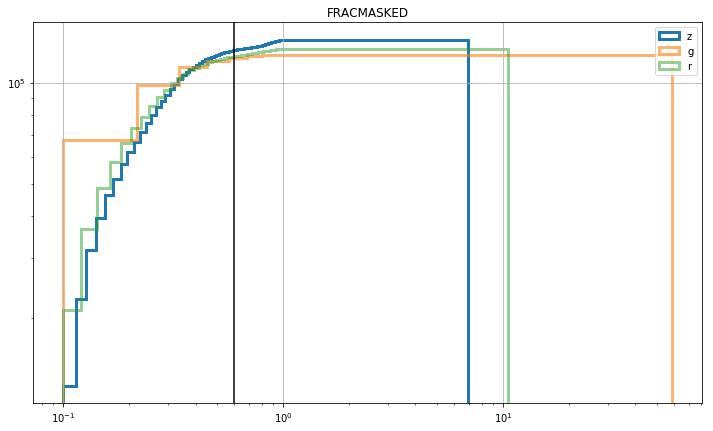

In [408]:
hist_decals(cat0, 'FRACMASKED', 0.1, 60, 0.6, 'loglog')

Z MAX-MIN= 6.94709 0.0
G MAX-MIN= 60.8369 0.0
R MAX-MIN= 10.5187 0.0


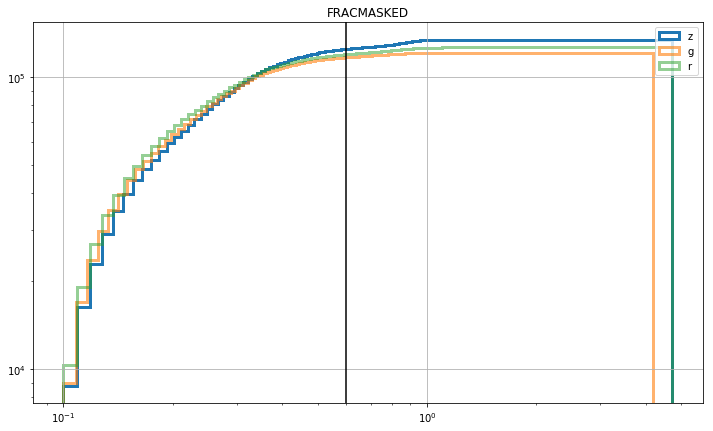

In [393]:
hist_decals(cat0, 'FRACMASKED', 0.1,5, 0.6, 'loglog')

Z MAX-MIN= 494118.0 -196.057
G MAX-MIN= 112529.0 -2175.9
R MAX-MIN= 7662.15 -1594.58


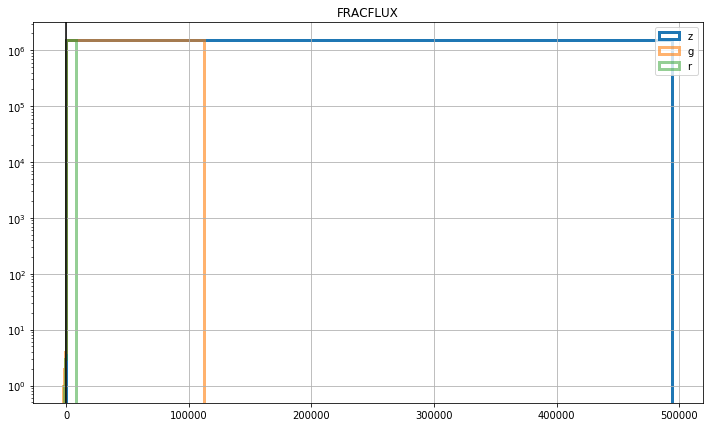

In [402]:
hist_decals(cat0, 'FRACFLUX', -2798.65, 494118.0, -0, 'logy')

Z MAX-MIN= 494118.0 -196.057
G MAX-MIN= 112529.0 -2175.9
R MAX-MIN= 7662.15 -1594.58


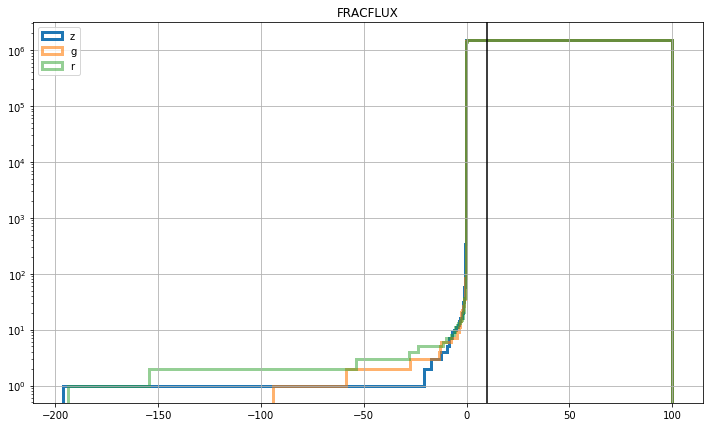

In [403]:
hist_decals(cat0, 'FRACFLUX', -200, 100, 10, 'logy')

Z MAX-MIN= 24 0
G MAX-MIN= 48 0
R MAX-MIN= 77 0


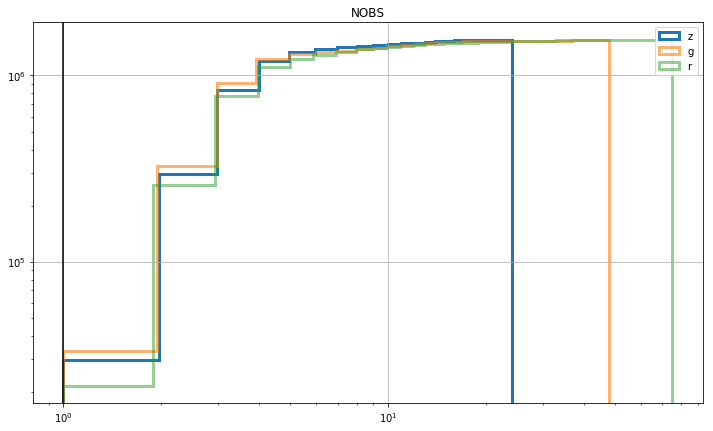

In [404]:
hist_decals(cat0, 'NOBS', 0.001, 77, 1, 'loglog')

Z MAX-MIN= 24 0
G MAX-MIN= 48 0
R MAX-MIN= 77 0


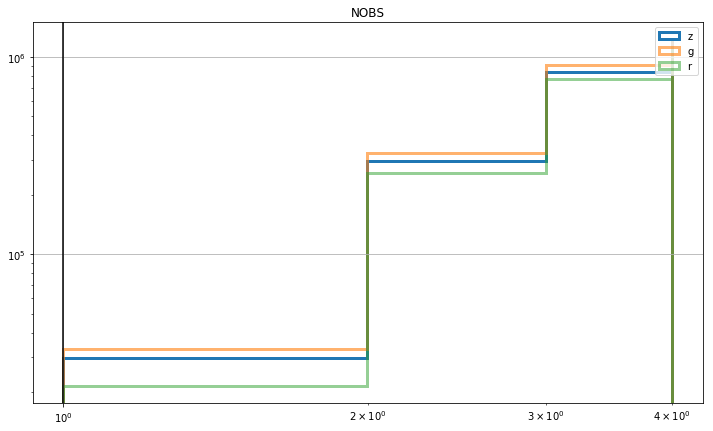

In [405]:
hist_decals(cat0, 'NOBS', 0.001, 5, 1, 'loglog')

Z MAX-MIN= 1837.22 3.71817e-17
G MAX-MIN= 16863.6 1.02488e-10
R MAX-MIN= 8911.74 3.02132e-11


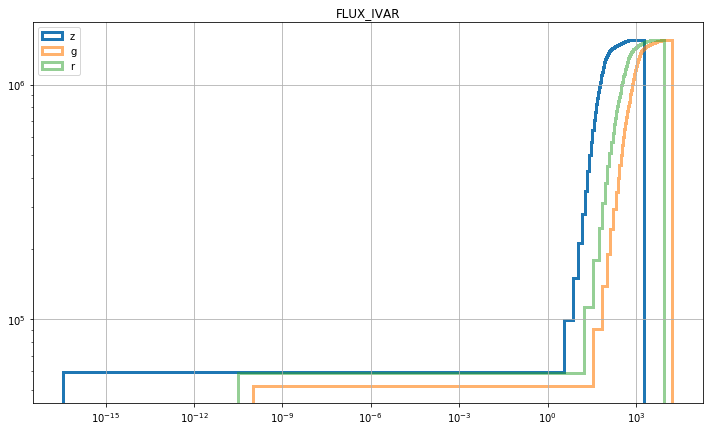

In [406]:
#* g+z-2*r<1.5 and g-r>-1. --This cuts junk where the r band or g band are anomalously bright
hist_decals(cat0, 'FLUX_IVAR', 0, 16863.6, 0, 'loglog')

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


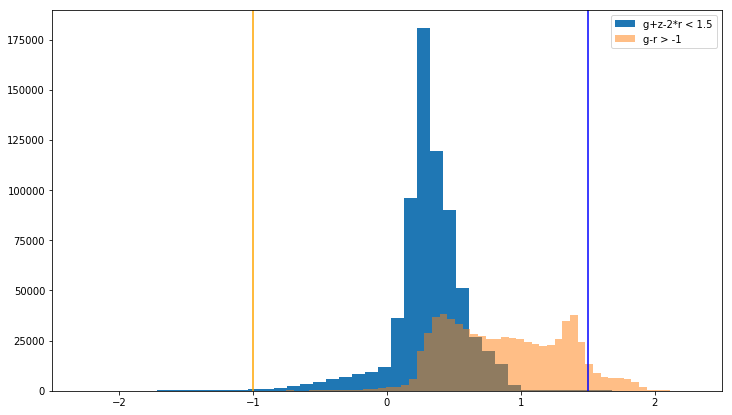

In [185]:
#del g, r, z, w1, G
g, r, z, w, G = get_mag_decals(cat0)
g = g[np.logical_and(r>=15, r<=20)]
z = z[np.logical_and(r>=15, r<=20)]
r = r[np.logical_and(r>=15, r<=20)]

plt.figure(figsize=(12, 7))
plt.hist(g+z-2*r, 300, label=r'g+z-2*r < 1.5')
plt.hist(g-r, 300, alpha=0.5, label=r'g-r > -1')
plt.axvline(x=1.5, color=r'blue')
plt.axvline(x=-1, color=r'orange')
plt.xlim(-2.5, 2.5)
plt.legend()